In [1]:
import torch
from stochastic.processes.continuous import FractionalBrownianMotion
import torch.nn as nn
from torch import Tensor
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

class DropoutFBM_with_branching(nn.Module):

    def __init__(self, hurst: float, n_agents: int, agent_len: int, max_iter: int, scale: float, grid_size: tuple, is_conv=False, show=False, device=None, dtype=None):

        super().__init__()
        
        self.hurst = hurst
        # independent FBM's for x and y coordinates
        self.agents_x = []
        self.agents_y = []
        # colors for each FBM droput agents
        self.colors = []
        # the number of FBM dropout agents = len(self.agents_x) = len(self.agents.y) = len(colors)
        self.n_agents = n_agents
        # the maximum number of forward calls during each epoch
        self.max_iter = max_iter
        # grid for neurons
        self.grid_size = grid_size
        # therefore, grid_size[0] * grid_size[1] = the total number of neurons
        self.n_neurons = grid_size[0] * grid_size[1]
        # true if the dropout is after a conv layer and false if after a linear layer
        self.is_conv = is_conv
        # true if want to print out the dropout grid
        self.show = show

        self.dtype = dtype
        self.device = device
        
        # keeps track of number iterations during each epoch
        self.current_iter = 0
        # keep track of total number of iterations during whole training
        self.total_iter = 0

        # keeps track of cummulative dropout rate = the sum of dropout rate / total iter
        self.sum_dropout_rate = 0.0
        self.cum_dropout_rate = 0.0

        # the sampling rate
        # sliding window length
        self.sequence_len = max_iter / scale
        self.agent_len = self.sliding_window_len = agent_len

        # initialize (x, y) of FBM dropout agents for max iterations and their color
        for _ in range(n_agents):
            # random starting point (x, y)
            x_starting_pt, y_starting_pt = torch.rand((1,)).item(), torch.rand((1,)).item()
            # get x FBM sequence with periodic boundary at [0, 1]
            fbm_x = FractionalBrownianMotion(hurst, t=self.sequence_len)
            self.agents_x.append((fbm_x.sample(max_iter * self.agent_len) + x_starting_pt) % 1)
            # get y FBM sequence with periodic boundary at [0, 1]
            fbm_y = FractionalBrownianMotion(hurst, t=self.sequence_len)
            self.agents_y.append((fbm_y.sample(max_iter * self.agent_len) + y_starting_pt) % 1)
            # get random (r, g, b) color
            color = torch.rand((3,))
            color = (color[0].item(), color[1].item(), color[2].item())
            self.colors.append(color)
        
        # initialize the grid of neurons
        self.grid = self.get_grid()

    def forward(self, input: Tensor) -> Tensor:
        
        # get new mask
        self.mask = self.get_mask()
        # move the mask to dtype and device
        if self.dtype:
            self.mask = self.mask.to(self.dtype)
        if self.device:
            self.mask = self.mask.to(self.device)

        # update iters
        self.current_iter += 1
        self.total_iter += 1
        # update dropout rates
        self.update_dropout_rate()

        # return input * mask * scale
        if self.now_dropout_rate > 0:
            return torch.mul(input, self.mask) * (1 / (1 - 1 / self.now_dropout_rate))
        else:
            return input
            
    def update_dropout_rate(self):
        self.now_dropout_rate = self.get_dropout_rate()
        self.sum_dropout_rate += self.now_dropout_rate
        self.cum_dropout_rate = self.sum_dropout_rate / self.total_iter

    def get_dropout_rate(self):
        return (1 - (torch.sum(self.mask) / (self.n_col * self.n_row))).item()
        
    def branch_off(self):

        agents_x = []
        agents_y = []
        for i in range(self.n_agents):
            # get a random starting point from the sequence from the previous epoch
            random_index = torch.randint(0, self.max_iter * self.agent_len, (1,)).item()
            x_starting_pt, y_starting_pt = self.agents_x[i][random_index], self.agents_y[i][random_index]
            
            # sample more starting from the starting point
            fbm_x = FractionalBrownianMotion(self.hurst, t=self.sequence_len)
            agents_x.append((fbm_x.sample(self.max_iter * self.agent_len) + x_starting_pt) % 1)
            fbm_y = FractionalBrownianMotion(self.hurst, t=self.sequence_len)
            agents_y.append((fbm_y.sample(self.max_iter * self.agent_len) + y_starting_pt) % 1)

        # update the sequences and current iter
        self.agents_x = agents_x
        self.agents_y = agents_y
        self.current_iter = 0

    def get_mask(self):

        return self.is_touching()

    def get_grid(self):

        self.n_row = n_row = self.grid_size[1]
        self.n_col = n_col = self.grid_size[0]

        # get size of rectangle for each neuron
        size_row = 1.0 / n_row
        size_col = 1.0 / n_col

        # partition the rectangle into 16 
        gap_y = size_row / 4
        gap_x = size_col / 4

        # for each neuron, out of 16, 4 in the middle are for neuron
        # and 12 on the boundary are for blank space
        grid = {}
        for x in range(n_col):
            for y in range(n_row):
                x_low = (x * size_col) + gap_x
                y_low = (y * size_row) + gap_y
                x_high = x_low + 2 * gap_x
                y_high = y_low + 2 * gap_y
                grid[(x,y)] = ((x_low, x_high), (y_low, y_high))

        return grid

    def is_touching(self):
        
        def is_in(agent_x, agent_y, g):
            # bounding box for a neuron
            ((x_low, x_high), (y_low, y_high)) = g
            # check if (x, y) is within the bounding box 
            for x,y  in zip(agent_x, agent_y):
                if x_low <= x and x <= x_high and y_low <= y and y <= y_high:
                    return True
            return False

        # initialize a mask
        is_touching = torch.ones(self.grid_size)

        
        t = self.current_iter*self.sliding_window_len
        # get (x, y) for current iteration
        curr_agent_x = [agent_x[t:t+self.agent_len] for agent_x in self.agents_x]
        curr_agent_y = [agent_y[t:t+self.agent_len] for agent_y in self.agents_y]
        # set is_touching[(i,j)] to 0 if (x,y) is within neuron (i,j)
        for i in range(self.n_col):
            for j in range(self.n_row):
                for x, y in zip(curr_agent_x, curr_agent_y):
                    if is_in(x, y, self.grid[(i,j)]):
                        is_touching[(i,j)] = 0
        
        # get (x, y) for all previous iterations
        prev_agent_x = [agent_x[:t] for agent_x in self.agents_x]
        prev_agent_y = [agent_y[:t] for agent_y in self.agents_y]
        # print the current grid status
        if self.show:
            fig, ax = plt.subplots(figsize=(10,10))
            # print the agents
            for i in range(self.n_agents):
                ax.scatter(prev_agent_x[i], prev_agent_y[i], s=3, color=self.colors[i], alpha=0.3)
                ax.scatter(curr_agent_x[i], curr_agent_y[i], s=10, color=self.colors[i])
            # print the neurons
            for x in range(self.n_col):
                for y in range(self.n_row):
                    ((x_low, x_high), (y_low, y_high)) = self.grid[(x,y)]
                    if is_touching[(x,y)]:
                        # set to black if not dropped out
                        facecolor = 'black'
                    else:
                        # set to red if dropped out
                        facecolor = 'red'
                    ax.add_patch(Rectangle((x_low, y_low), x_high - x_low, y_high - y_low,
                                           facecolor=facecolor, zorder=0))
            ax.set_aspect('equal')
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_title('Dropout rate: {:2f}'.format((1 - (torch.sum(is_touching) / (self.n_col * self.n_row)).item())))
            plt.show()
        
        # rotate 90 degrees
        is_touching = torch.rot90(is_touching)
        if self.is_conv:
            return is_touching
        # flatten for linear layer
        return is_touching.reshape(-1)

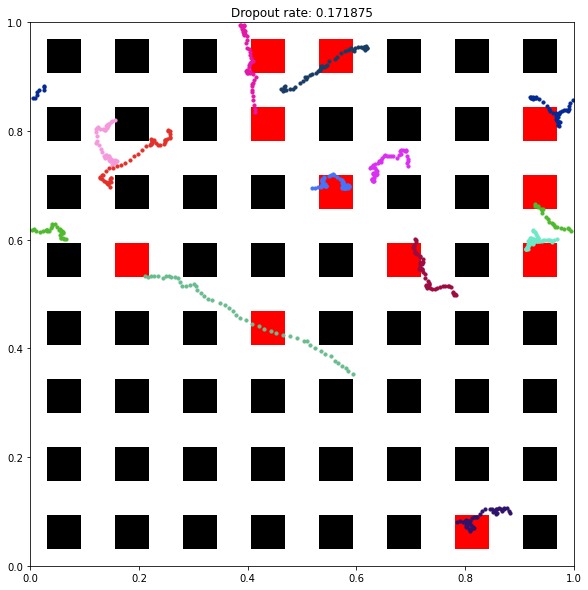

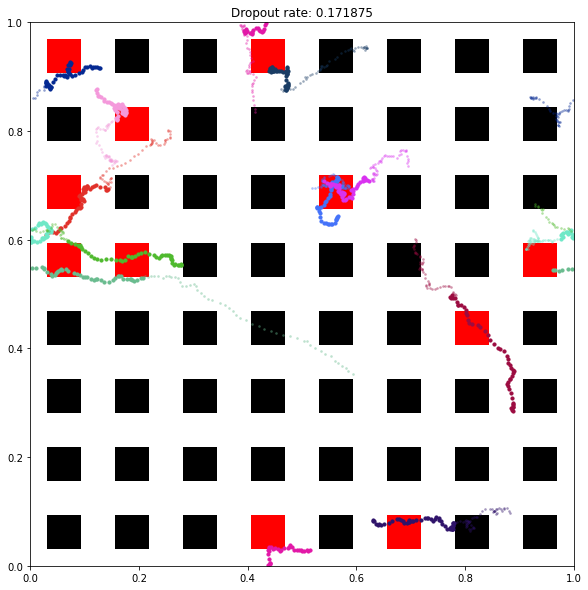

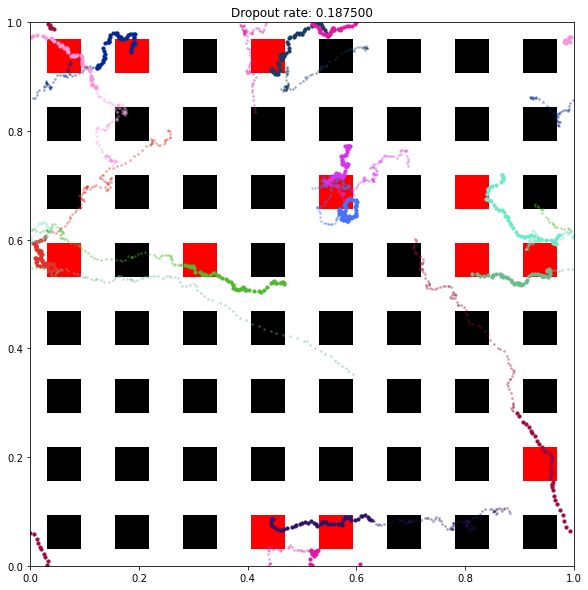

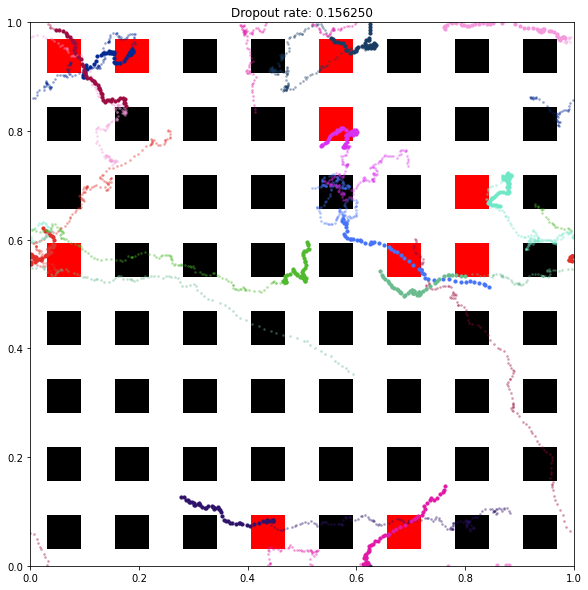

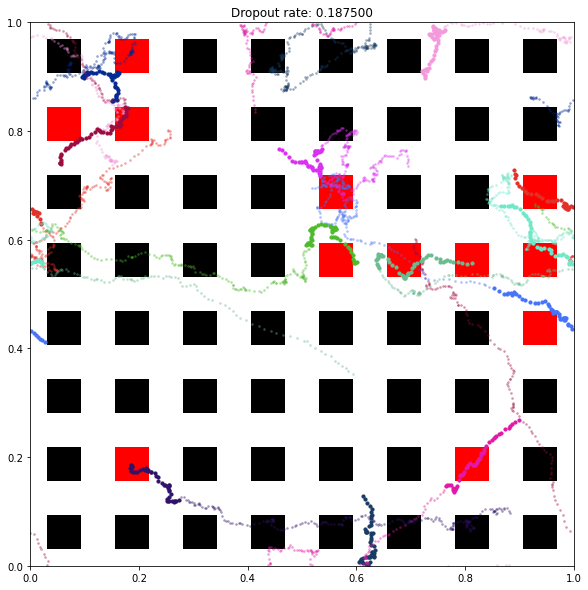

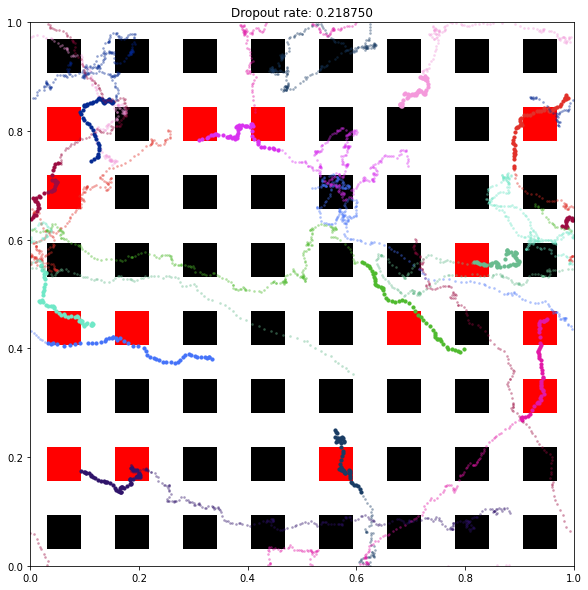

In [6]:
dropout = DropoutFBM_with_branching(0.9, 12, 50, 6, 10.0, (8, 8), show=True)
a = torch.randn((64,))

out = dropout(a)
out = dropout(a)
out = dropout(a)
out = dropout(a)
out = dropout(a)
out = dropout(a)